In [1]:
#import datasets
import pandas as pd
import numpy as np



In [2]:
horse = pd.read_csv("horse_original.csv")


In [3]:
horse.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [4]:
print(horse.columns.tolist())


['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance', 'abdomo_protein', 'outcome', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3', 'cp_data']


In [5]:
# dropping hospital number
horse = horse.drop(['hospital_number'], axis=1)

In [6]:
# convert na imputs to NA

horse = horse.replace(["na", "NA"], np.nan)


In [7]:
# 1. Total rows
print(len(horse))
print()
# 2. Non-NA count per feature
print(horse.notna().sum())


299

surgery                  299
age                      299
rectal_temp              239
pulse                    275
respiratory_rate         241
temp_of_extremities      243
peripheral_pulse         230
mucous_membrane          252
capillary_refill_time    267
pain                     244
peristalsis              255
abdominal_distention     243
nasogastric_tube         195
nasogastric_reflux       193
nasogastric_reflux_ph     53
rectal_exam_feces        197
abdomen                  181
packed_cell_volume       270
total_protein            266
abdomo_appearance        134
abdomo_protein           101
outcome                  299
surgical_lesion          299
lesion_1                 299
lesion_2                 299
lesion_3                 299
cp_data                  299
dtype: int64


In [8]:
cols = ["lesion_1", "lesion_2", "lesion_3"]
print((horse[cols] != 0).sum())


lesion_1    243
lesion_2      7
lesion_3      1
dtype: int64


In [9]:
# we have only 7 and 1 values of lesion 7 and lesion 1, will be
# where most horses lived (except 1 euthanised), not sufficient info is gained
# thus we will drop them:

horse = horse.drop(['lesion_2', 'lesion_3'], axis=1)

In [10]:
def decode_lesion(code):
    if pd.isna(code):
        return [np.nan, np.nan, np.nan, np.nan]
    
    code = str(int(float(code))) if str(code).replace('.', '', 1).isdigit() else str(code).strip()
    length = len(code)

    if code == '0':
        return [0, 0, 0, 0]

    site = lesion_type = subtype = specific = np.nan

    if length == 4:
        site, lesion_type, subtype, specific = code[0], code[1], code[2], code[3]

    elif length == 5:
        first_two, last_two = code[:2], code[-2:]

        if first_two in ["00", "11"]:
            site, lesion_type, subtype, specific = first_two, code[2], code[3], code[4]
        elif last_two == "10":
            site, lesion_type, subtype, specific = code[0], code[1], code[2], last_two
        else:
            site, lesion_type, subtype, specific = code[0], code[1], code[2], code[3]
    else:
        code = code.ljust(4, '0')
        site, lesion_type, subtype, specific = code[:4]

    if site == '00':
        site = np.nan

    return [site, lesion_type, subtype, specific]


# --- APPLY ONLY TO LESION_1 ---

df_lesion = horse.copy()

decoded = df_lesion['lesion_1'].apply(decode_lesion)
decoded_df = pd.DataFrame(
    decoded.tolist(),
    columns=['lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific'],
    index=df_lesion.index
)

df_lesion = df_lesion.drop(columns=['lesion_1'], errors='ignore')
df_lesion = pd.concat([df_lesion, decoded_df], axis=1)

df_lesion[['lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific']] = (
    df_lesion[['lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific']]
    .apply(pd.to_numeric, errors='coerce')
)

def count_lesions(r):
    x = r.get('lesion_1_site')
    return 1 if pd.notna(x) and x != 0 else 0

df_lesion['num_lesions'] = df_lesion.apply(count_lesions, axis=1)

horse = df_lesion.copy()


In [11]:
print(horse.columns.tolist())

print(horse[["lesion_1_site", "lesion_1_type", "lesion_1_subtype", "lesion_1_specific", "num_lesions"]].head())



['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance', 'abdomo_protein', 'outcome', 'surgical_lesion', 'cp_data', 'lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific', 'num_lesions']
   lesion_1_site  lesion_1_type  lesion_1_subtype  lesion_1_specific  \
0             11              3                 0                  0   
1              2              2                 0                  8   
2              0              0                 0                  0   
3              2              2                 0                  8   
4              4              3                 0                  0   

   num_lesions  
0            1  
1            1  
2          

In [12]:
# --- numeric features ---
numeric_features = [
    "rectal_temp",
    "pulse",
    "respiratory_rate",
    "nasogastric_reflux_ph",
    "packed_cell_volume",
    "total_protein",
    "abdomo_protein"
]

# --- ordinal features (exact spellings already in your dataframe) ---
ordinal_features = [
    "temp_of_extremities",
    "peripheral_pulse",
    "abdominal_distention",
    "nasogastric_tube",
    "nasogastric_reflux",
    "rectal_exam_feces",
    "abdomen"
]

# --- categorical = remaining columns not in numeric or ordinal ---
categorical_features = [
    col for col in horse.columns
    if col not in numeric_features + ordinal_features
]

print("Numeric:", numeric_features)
print("Ordinal:", ordinal_features)
print("Categorical:", categorical_features)


Numeric: ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein']
Ordinal: ['temp_of_extremities', 'peripheral_pulse', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen']
Categorical: ['surgery', 'age', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdomo_appearance', 'outcome', 'surgical_lesion', 'cp_data', 'lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific', 'num_lesions']


In [13]:
horse.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,cp_data,lesion_1_site,lesion_1_type,lesion_1_subtype,lesion_1_specific,num_lesions
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,...,NaN,NaN,died,no,no,11,3,0,0,1
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,...,cloudy,2.0,euthanized,no,no,2,2,0,8,1
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,...,NaN,NaN,lived,no,yes,0,0,0,0,0
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,...,serosanguious,5.3,died,yes,yes,2,2,0,8,1
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,...,NaN,NaN,died,no,no,4,3,0,0,1


In [14]:
horse.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,cp_data,lesion_1_site,lesion_1_type,lesion_1_subtype,lesion_1_specific,num_lesions
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,...,NaN,NaN,died,no,no,11,3,0,0,1
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,...,cloudy,2.0,euthanized,no,no,2,2,0,8,1
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,...,NaN,NaN,lived,no,yes,0,0,0,0,0
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,...,serosanguious,5.3,died,yes,yes,2,2,0,8,1
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,...,NaN,NaN,died,no,no,4,3,0,0,1


In [15]:
import pandas as pd

# --- define ordinal maps (based on your ranks) ---
ordinal_maps = {
    "temp_of_extremities": {
        "cool": 0,
        "normal": 1,
        "warm": 2
    },
    "peripheral_pulse": {
        "absent": 0,
        "reduced": 1,
        "normal": 2
    },
    "abdominal_distention": {
        "none": 0,
        "slight": 1,
        "moderate": 2,
        "severe": 3
    },
    "nasogastric_tube": {
        "none": 0,
        "slight": 1,
        "significant": 2
    },
    "nasogastric_reflux": {
        "none": 0,
        "less_1_liter": 1,
        "more_1_liter": 2
    },
    "rectal_exam_feces": {
        "absent": 0,
        "decreased": 1,
        "normal": 2,
        "increased": 3
    },
    "abdomen": {
        "normal": 0,
        "distend_small": 1,
        "distend_large": 2
    }
}

# --- apply ordinal encoding and store encoded dataframe ---
horse_ord = horse.copy()

for col, mapping in ordinal_maps.items():
    horse_ord[col] = horse_ord[col].map(mapping)

# mapping preserved in ordinal_maps dictionary
print(ordinal_maps)
print(horse_ord[ordinal_maps.keys()].head())

horse = horse_ord.copy()



{'temp_of_extremities': {'cool': 0, 'normal': 1, 'warm': 2}, 'peripheral_pulse': {'absent': 0, 'reduced': 1, 'normal': 2}, 'abdominal_distention': {'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3}, 'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2}, 'nasogastric_reflux': {'none': 0, 'less_1_liter': 1, 'more_1_liter': 2}, 'rectal_exam_feces': {'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3}, 'abdomen': {'normal': 0, 'distend_small': 1, 'distend_large': 2}}
   temp_of_extremities  peripheral_pulse  abdominal_distention  \
0                  0.0               1.0                   3.0   
1                  NaN               NaN                   1.0   
2                  1.0               2.0                   0.0   
3                  NaN               2.0                   3.0   
4                  NaN               NaN                   NaN   

   nasogastric_tube  nasogastric_reflux  rectal_exam_feces  abdomen  
0               NaN                 NaN         

In [16]:
horse.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,cp_data,lesion_1_site,lesion_1_type,lesion_1_subtype,lesion_1_specific,num_lesions
0,no,adult,38.5,66.0,28.0,0.0,1.0,NaN,more_3_sec,extreme_pain,...,NaN,NaN,died,no,no,11,3,0,0,1
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,...,cloudy,2.0,euthanized,no,no,2,2,0,8,1
2,no,adult,38.3,40.0,24.0,1.0,2.0,pale_pink,less_3_sec,mild_pain,...,NaN,NaN,lived,no,yes,0,0,0,0,0
3,yes,young,39.1,164.0,84.0,NaN,2.0,dark_cyanotic,more_3_sec,depressed,...,serosanguious,5.3,died,yes,yes,2,2,0,8,1
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,...,NaN,NaN,died,no,no,4,3,0,0,1


Will compare imputation methods

In [20]:
from sklearn.impute import SimpleImputer

categorical_imputer = SimpleImputer(strategy="most_frequent")

horse_cat_imputed = horse_ord.copy()

for col in categorical_features:
    horse_cat_imputed[col] = categorical_imputer.fit_transform(
        horse_cat_imputed[[col]]
    ).ravel()    # ✅ flatten from (n,1) → (n,)

horse_imp = horse_cat_imputed.copy()

In [21]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors=5)

# Apply KNN only on numeric + ordinal together
knn_cols = numeric_features + ordinal_features

horse_knn = horse_imp.copy()
horse_knn[knn_cols] = knn.fit_transform(horse_imp[knn_cols])

for col in ordinal_features:
    horse_knn[col] = horse_knn[col].round().astype(int)



In [22]:
# Categorical data encoding

cat_maps = {}        # store the conversions
horse_encoded = horse_knn.copy()

for col in categorical_features:
    unique_vals = horse_encoded[col].astype(str).unique()
    mapping = {v: i for i, v in enumerate(unique_vals)}
    cat_maps[col] = mapping
    horse_encoded[col] = horse_encoded[col].astype(str).map(mapping)

# print to verify
print(cat_maps)

horse = horse_encoded.copy()


{'surgery': {'no': 0, 'yes': 1}, 'age': {'adult': 0, 'young': 1}, 'mucous_membrane': {'normal_pink': 0, 'pale_cyanotic': 1, 'pale_pink': 2, 'dark_cyanotic': 3, 'bright_red': 4, 'bright_pink': 5}, 'capillary_refill_time': {'more_3_sec': 0, 'less_3_sec': 1, '3': 2}, 'pain': {'extreme_pain': 0, 'mild_pain': 1, 'depressed': 2, 'severe_pain': 3, 'alert': 4}, 'peristalsis': {'absent': 0, 'hypomotile': 1, 'hypermotile': 2, 'normal': 3}, 'abdomo_appearance': {'cloudy': 0, 'serosanguious': 1, 'clear': 2}, 'outcome': {'died': 0, 'euthanized': 1, 'lived': 2}, 'surgical_lesion': {'no': 0, 'yes': 1}, 'cp_data': {'no': 0, 'yes': 1}, 'lesion_1_site': {'11': 0, '2': 1, '0': 2, '4': 3, '3': 4, '1': 5, '7': 6, '5': 7, '9': 8, '6': 9, '8': 10}, 'lesion_1_type': {'3': 0, '2': 1, '0': 2, '1': 3, '4': 4}, 'lesion_1_subtype': {'0': 0, '2': 1, '1': 2, '3': 3}, 'lesion_1_specific': {'0': 0, '8': 1, '4': 2, '5': 3, '1': 4, '2': 5, '7': 6, '9': 7, '3': 8, '6': 9, '10': 10}, 'num_lesions': {'1': 0, '0': 1}}


In [23]:
#  Making a non encoded version for GNU Octave

# invert categorical maps
cat_maps_inv = {
    col: {v: k for k, v in mapping.items()}
    for col, mapping in cat_maps.items()
}

# invert ordinal maps
ordinal_maps_inv = {
    col: {v: k for k, v in mapping.items()}
    for col, mapping in ordinal_maps.items()
}

horse_imputed_only = horse.copy()

# decode categorical features
for col, inv_map in cat_maps_inv.items():
    if col in horse_imputed_only.columns:
        horse_imputed_only[col] = horse_imputed_only[col].map(inv_map)

# decode ordinal features
for col, inv_map in ordinal_maps_inv.items():
    if col in horse_imputed_only.columns:
        horse_imputed_only[col] = horse_imputed_only[col].map(inv_map)

print(horse_imputed_only.head())

horse_imputed_only.to_csv("horse_imputed_only.csv", index=False)


  surgery    age  rectal_temp  pulse  respiratory_rate temp_of_extremities  \
0      no  adult         38.5   66.0              28.0                cool   
1     yes  adult         39.2   88.0              20.0              normal   
2      no  adult         38.3   40.0              24.0              normal   
3     yes  young         39.1  164.0              84.0                cool   
4      no  adult         37.3  104.0              35.0                cool   

  peripheral_pulse mucous_membrane capillary_refill_time          pain  ...  \
0          reduced     normal_pink            more_3_sec  extreme_pain  ...   
1          reduced   pale_cyanotic            less_3_sec     mild_pain  ...   
2           normal       pale_pink            less_3_sec     mild_pain  ...   
3           normal   dark_cyanotic            more_3_sec     depressed  ...   
4          reduced   dark_cyanotic            more_3_sec     mild_pain  ...   

  abdomo_appearance abdomo_protein     outcome surgical_

In [24]:
# 2. Non-NA count per feature
print(horse.notna().sum())


surgery                  299
age                      299
rectal_temp              299
pulse                    299
respiratory_rate         299
temp_of_extremities      299
peripheral_pulse         299
mucous_membrane          299
capillary_refill_time    299
pain                     299
peristalsis              299
abdominal_distention     299
nasogastric_tube         299
nasogastric_reflux       299
nasogastric_reflux_ph    299
rectal_exam_feces        299
abdomen                  299
packed_cell_volume       299
total_protein            299
abdomo_appearance        299
abdomo_protein           299
outcome                  299
surgical_lesion          299
cp_data                  299
lesion_1_site            299
lesion_1_type            299
lesion_1_subtype         299
lesion_1_specific        299
num_lesions              299
dtype: int64


In [25]:
# Scalin the numeric values:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

horse_scaled = horse.copy()
horse_scaled[numeric_features] = scaler.fit_transform(horse_scaled[numeric_features])


In [26]:
horse_scaled.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,cp_data,lesion_1_site,lesion_1_type,lesion_1_subtype,lesion_1_specific,num_lesions
0,0,0,0.423127,-0.221534,-0.146624,0,1,0,0,0,...,0,0.533042,0,0,0,0,0,0,0,0
1,1,0,1.440998,0.573734,-0.641268,1,1,1,1,1,...,0,-0.830609,1,0,0,1,1,0,1,0
2,0,0,0.132306,-1.161395,-0.393946,1,2,2,1,1,...,0,0.490867,2,0,1,2,2,0,0,1
3,1,1,1.295588,3.321020,3.315887,0,2,3,0,2,...,1,1.489003,0,1,1,1,1,0,1,0
4,0,0,-1.321796,1.152110,0.286190,0,1,3,0,1,...,0,0.265935,0,0,0,3,0,0,0,0


Lets do PCA Now
 

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = horse_scaled.drop(columns=["outcome"], errors="ignore")   # optional
y = horse_scaled["outcome"] if "outcome" in horse_scaled.columns else None


In [28]:
# ----------------------------
# 2. FULL PCA FIT (to compute variance curve)
# ----------------------------

pca = PCA()
X_pca_full = pca.fit_transform(X)

explained = np.cumsum(pca.explained_variance_ratio_)


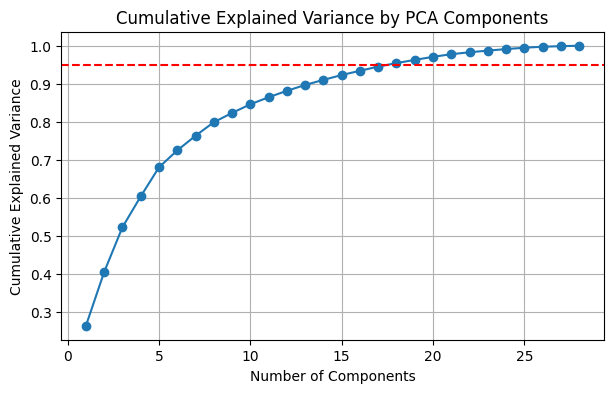

In [29]:
# ----------------------------
# 3. PLOT EXPLAINED VARIANCE
# ----------------------------

plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [30]:
# ----------------------------
# 4. SELECT COMPONENTS THAT EXPLAIN ≥ 95% VARIANCE
# ----------------------------

n_components = np.argmax(explained >= 0.95) + 1
print(f"✅ PCA keeps {n_components} components to reach ≥95% variance")


✅ PCA keeps 18 components to reach ≥95% variance


In [31]:
# ----------------------------
# 5. FINAL PCA REDUCTION
# ----------------------------

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
print("Reduced PCA dataset shape:", df_pca.shape)


Reduced PCA dataset shape: (299, 18)


In [32]:
# ----------------------------
# 6. t-SNE ON PCA DATA
# ----------------------------

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(df_pca)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])

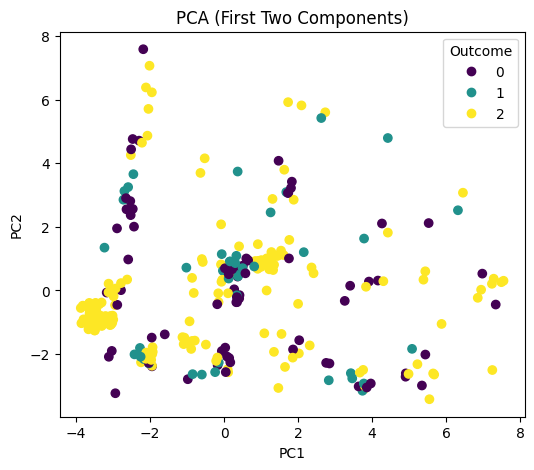

In [33]:
# ----------------------------
# 7. PLOTTING PCA (2D)
# ----------------------------

plt.figure(figsize=(6,5))
sc = plt.scatter(df_pca["PC1"], df_pca["PC2"], c=y, cmap="viridis")
plt.title("PCA (First Two Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Build legend from outcome classes
classes = np.unique(y)
cmap = plt.get_cmap("viridis")
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i/(len(classes)-1)), label=str(cls))
    for i, cls in enumerate(classes)
]
plt.legend(handles=handles, title="Outcome")

plt.show()


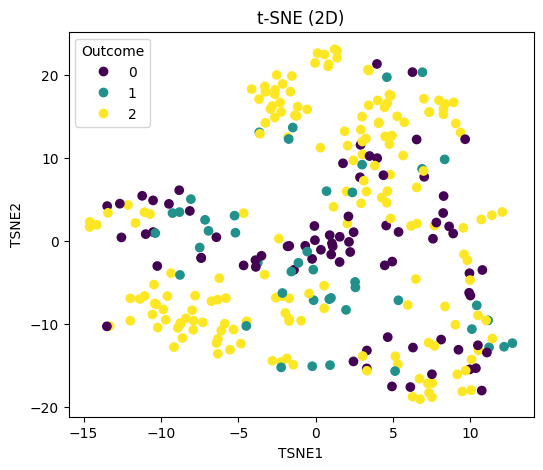

In [34]:
# ----------------------------
# 8. PLOTTING t-SNE (2D)
# ----------------------------

plt.figure(figsize=(6,5))
sc = plt.scatter(df_tsne["TSNE1"], df_tsne["TSNE2"], c=y, cmap="viridis")
plt.title("t-SNE (2D)")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Same legend
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i/(len(classes)-1)), label=str(cls))
    for i, cls in enumerate(classes)
]
plt.legend(handles=handles, title="Outcome")

plt.show()

In [35]:
horse.to_csv("horse_No_scaling.csv", index=False)
horse_scaled.to_csv("horse_scaled.csv", index = False)


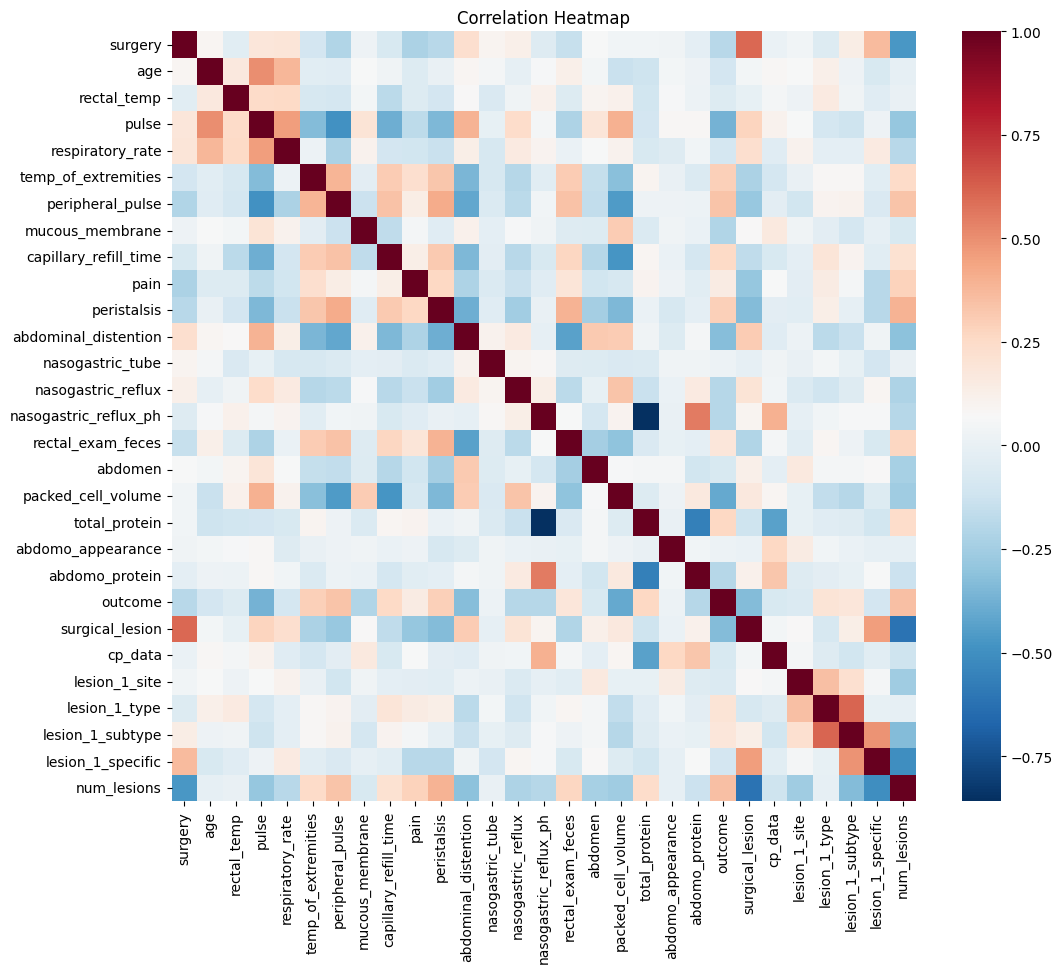

In [36]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(horse.corr(), cmap="RdBu_r", annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [37]:
from sklearn.feature_selection import f_classif

# X = features, y = outcome (encoded)
X = horse.drop(columns=["outcome"])
y = horse["outcome"]

# compute F-values and p-values
F, p = f_classif(X, y)

feature_scores = pd.DataFrame({
    "feature": X.columns,
    "F_value": F,
    "p_value": p
}).sort_values(by="F_value", ascending=False)

print(feature_scores.head(10))


                  feature    F_value       p_value
17     packed_cell_volume  31.337358  4.523352e-13
6        peripheral_pulse  26.911631  1.826282e-11
27            num_lesions  24.743728  1.156632e-10
3                   pulse  24.691670  1.209396e-10
18          total_protein  23.672691  2.903716e-10
11   abdominal_distention  21.479441  1.947218e-09
21        surgical_lesion  18.672057  2.306961e-08
14  nasogastric_reflux_ph  17.418306  7.052866e-08
5     temp_of_extremities  16.973035  1.051030e-07
8   capillary_refill_time  16.587173  1.486374e-07


In [38]:
print(horse.columns.tolist())

['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance', 'abdomo_protein', 'outcome', 'surgical_lesion', 'cp_data', 'lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_specific', 'num_lesions']
